## 3.6 STL decomposition

STL decomposition, short for Seasonal and Trend decomposition using Loess, is a technique for breaking down a time series into three components:
- **Trend** ($T_t$): The long-term progression or underlying direction of the data.
- **Seasonal** ($S_t$): Regular, repeating patterns over a fixed period, like daily, monthly, or yearly cycles.
- **Residual** ($R_t$): The remaining variation after removing the trend and seasonal components, often treated as noise or unexplained variability.

Mathematically, STL assumes the time series $Y_t$ can be expressed as:
$$
Y_t = T_t + S_t + R_t,
$$
i.e. decomposition is additive.

### Intuitive Steps in STL Decomposition:
1. Extract the Seasonal Component ($S_t$):
- For a given time series, the seasonal component captures regular patterns.
- STL uses a **Loess smoother** (a local regression method) to estimate seasonal patterns. It calculates the seasonal cycle for each period (e.g., months in a year) and ensures that these patterns are smooth across periods.
2. Estimate the Trend ($T_t$)
- After removing the seasonal component, the remaining data ($Y_t-S_t$) is used to estimate the trend.
- The trend captures the slow-moving changes in the data over time (e.g., an upward or downward slope) and is also computed using a Loess smoother.
3. Compute the Residual ($R_t$):
- Once the trend ($T_t$) and seasonal ($S_t$) components are estimated, the residual is simply:
$$
R_t = Y_t - T_t - S_t
$$
- This residual represents irregular fluctuations not captured by the trend or seasonal components.

### Why STL is useful:
- **Flexibility in Seasonality**: STL handles non-constant seasonal patterns, meaning the magnitude of seasonality can change over time.
- **Robustness to Outliers**: By using robust smoothing techniques, STL can handle outliers effectively without distorting the trend or seasonal components.
- **Adjustable Smoothness**: Can control how smooth the seasonal and trend components should be.
### Disadvantages:
- Does not handle trading day or calendar variations automatically
- Only provides facilities for additive decompositions.

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.0)
from plotnine import aes, ggplot, labs, geom_line, theme

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)


In [2]:
df_employment = pd.read_csv('../data/fpp3/us_employment.csv')

In [6]:
us_retail_employment = (df_employment
                        .assign(date=pd.to_datetime(df_employment['Month'], format='%Y %b'))
                        .assign(year=lambda df: df['date'].dt.year)
                        .query("year >= 1990 and Title == 'Retail Trade'")
                        .drop(columns=['year', 'Series_ID'])
                        )

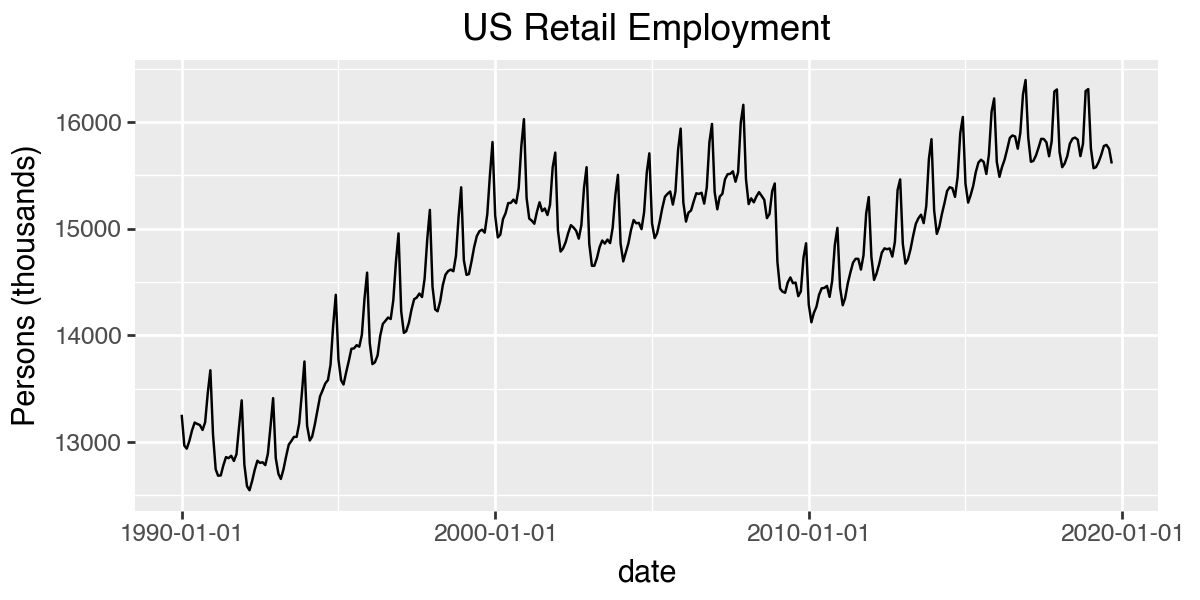

In [8]:
ggplot(us_retail_employment) \
    + aes(x='date', y='Employed') \
    + geom_line() \
    + labs(y='Persons (thousands)',
        title='US Retail Employment') \
    + theme(figure_size=(6, 3))

In [26]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

#### STL decomposition in statsmodels 
[Documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html)

In [27]:
stl = STL(us_retail_employment.set_index('date').Employed, robust=True)
res_robust = stl.fit()


In [16]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


In [ ]:
fig = res_robust.plot()
res_non_robust = STL(us_retail_employment.set_index('date')['Employed'], robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

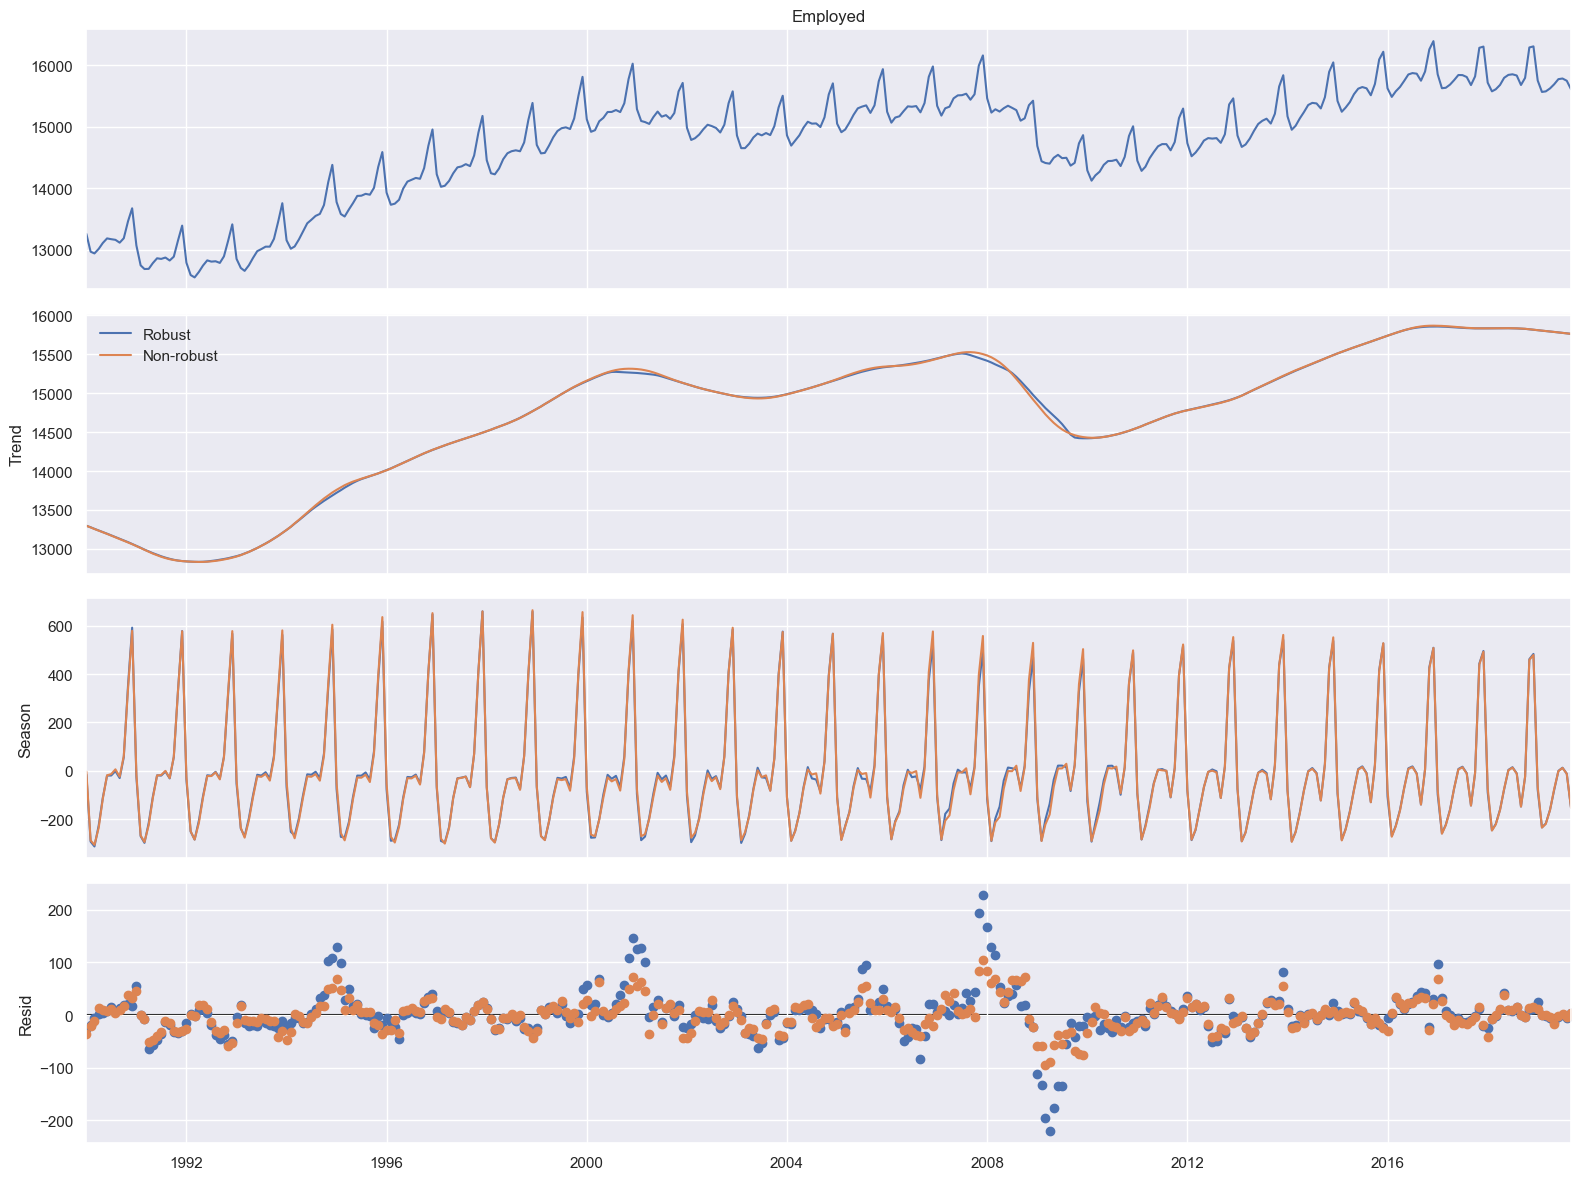

In [31]:
fig

#### Seasonal component
Seasonal component from the decomposition show in the previous figure. This allows us to see the change in magnitude of the seasonal component over time.

In [43]:
from plotnine import facet_grid, element_text, labeller, geom_hline

In [37]:
df_seasonal = (res_robust.seasonal
    .reset_index()
    .assign(year=lambda df: df['date'].dt.year)
    .assign(month=lambda df: df['date'].dt.month)
)


In [45]:
def col_fn(n):
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    return months[int(n)-1]

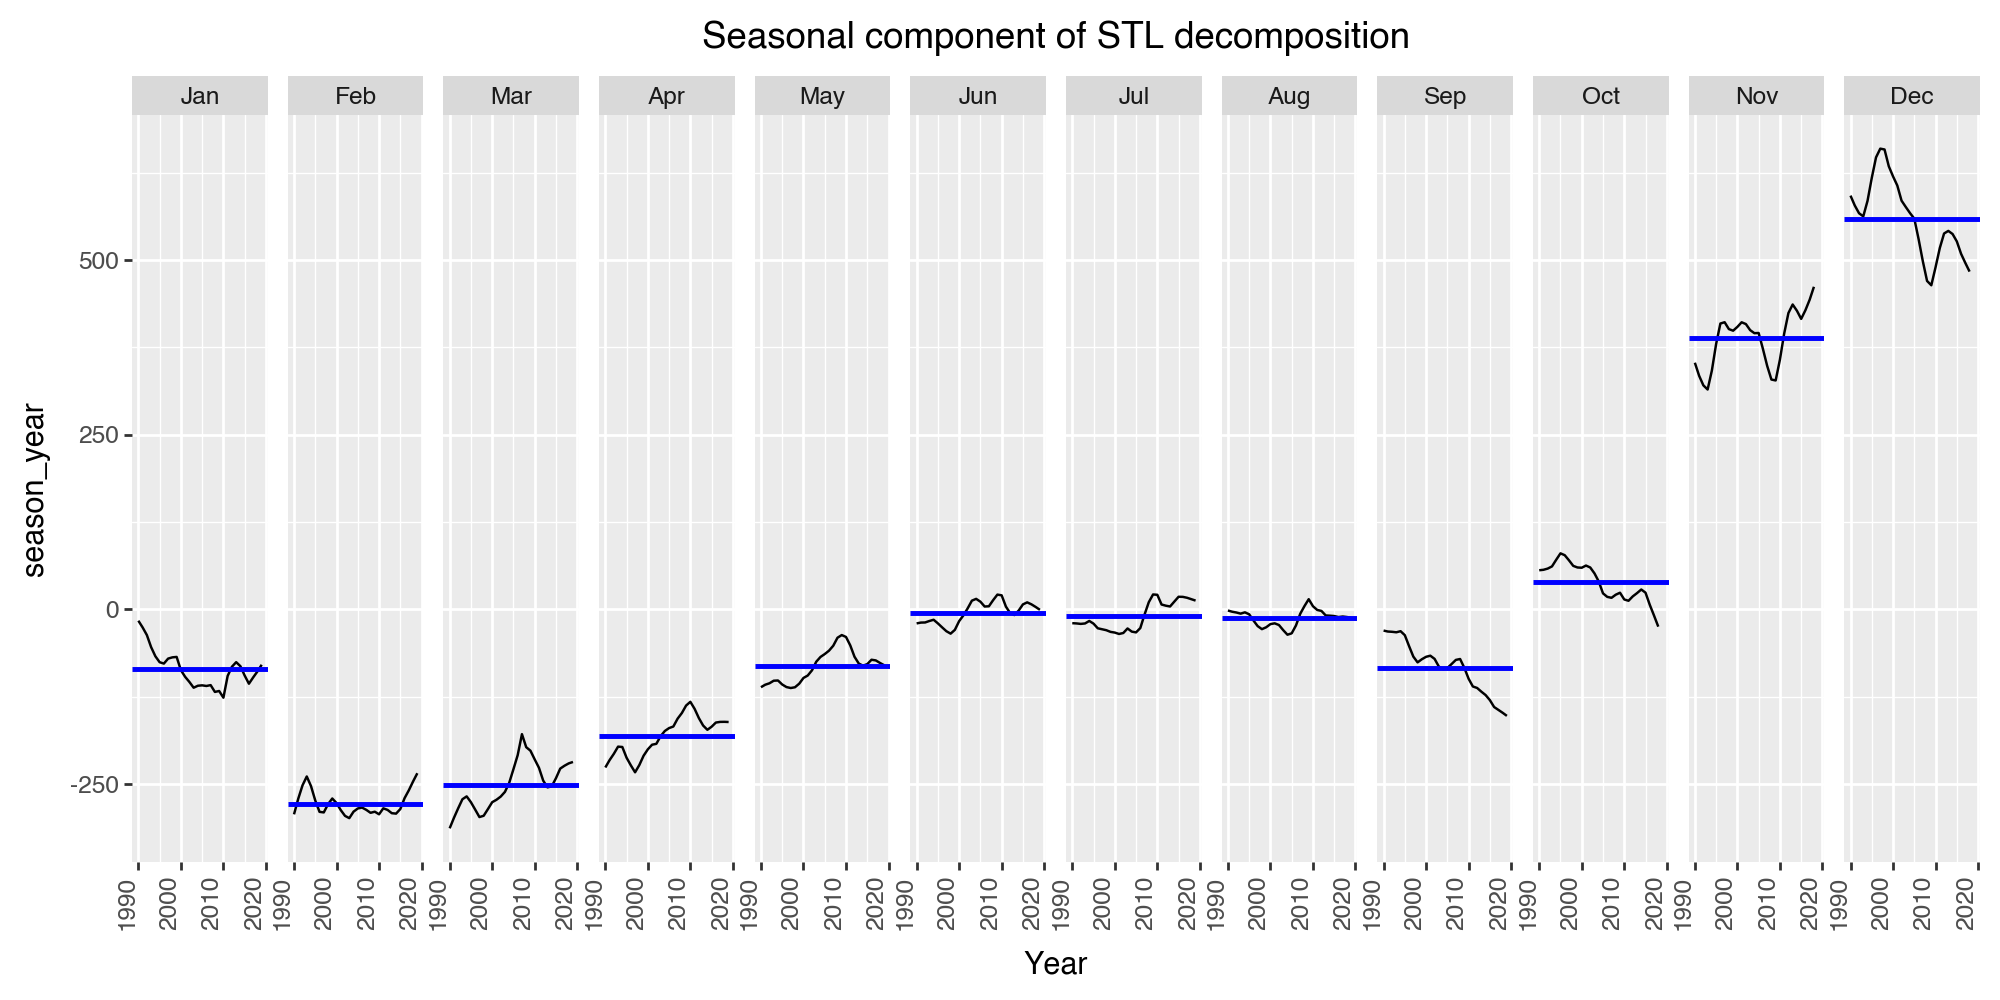

In [53]:
ggplot(df_seasonal) \
    + aes(x='year', y='season') \
    + facet_grid(cols='month', labeller=labeller(cols=col_fn)) \
    + geom_line() \
    + geom_hline(data=df_seasonal.groupby('month').agg({'season': 'mean'}).reset_index(),
        mapping=aes(yintercept='season'), color='blue', size=1) \
    + labs(title='Seasonal component of STL decomposition', x='Year', y='season_year') \
    + theme(axis_text_x=element_text(rotation=90, hjust=1), figure_size=(10, 5))

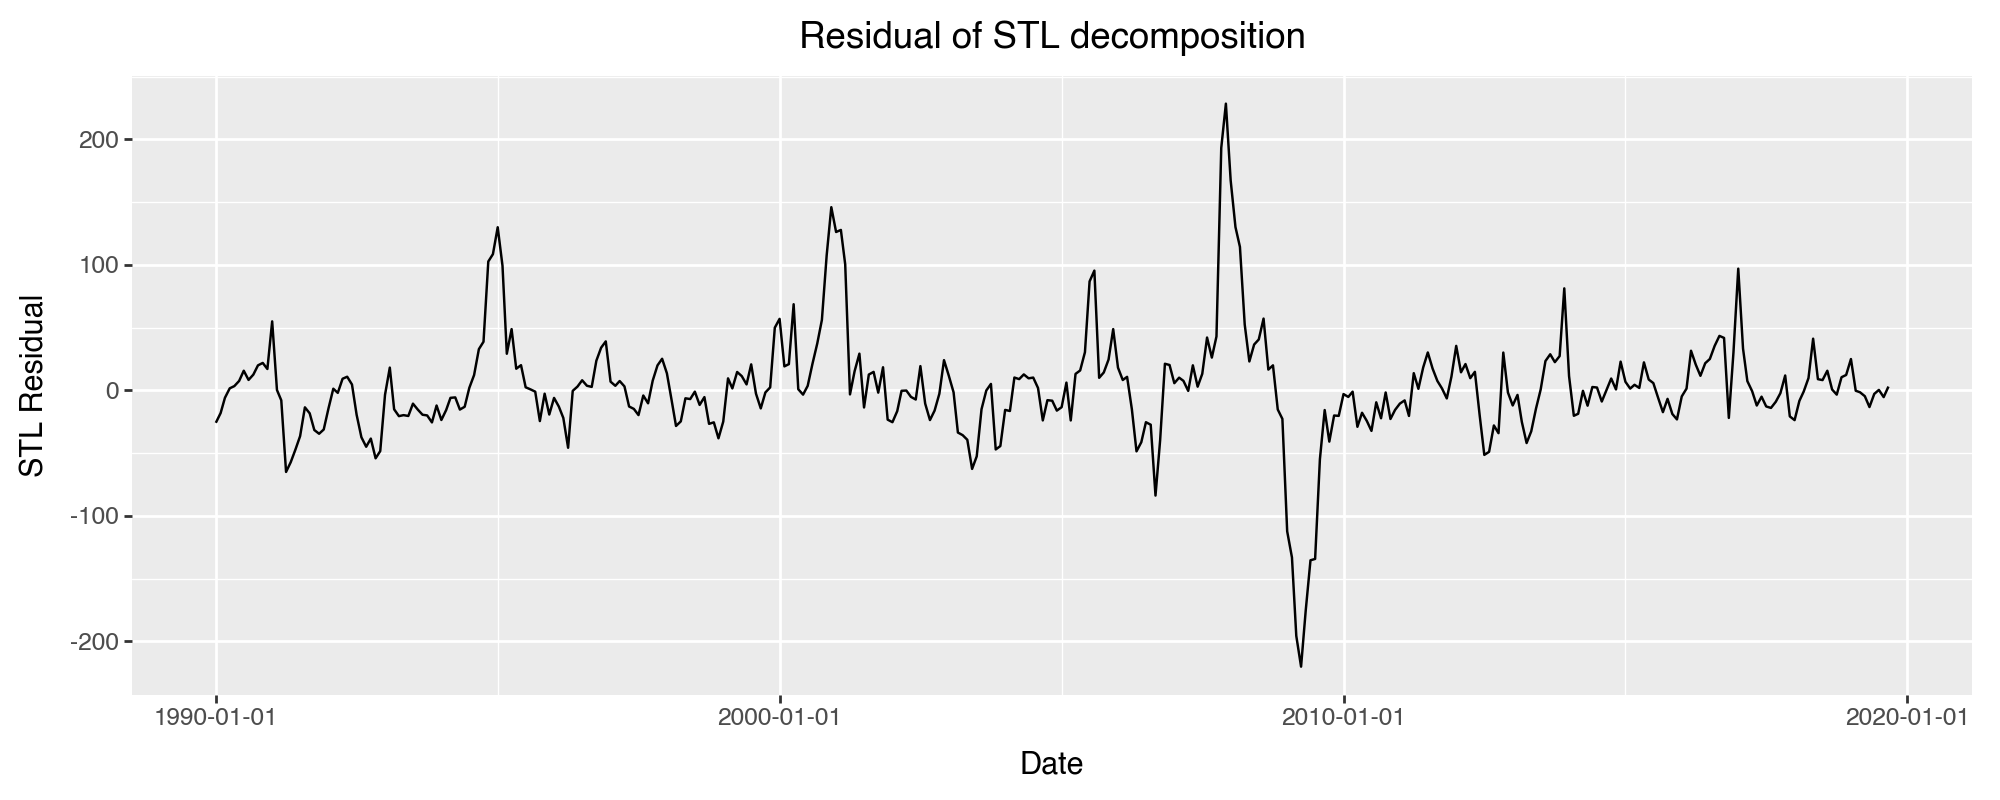

In [52]:
ggplot(res_robust.resid.reset_index()) \
    + aes(x='date', y='resid') \
    + geom_line() \
    + labs(x='Date', y='STL Residual', title='Residual of STL decomposition') \
    + theme(figure_size=(10, 4))